# Recurrent Neural Networks

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Overview

The structure of the direcotry should be as follows:

```
.
├── data
│   ├── train.pkl
│   └── test_no_target.pkl
└── main.ipynb
```



## Setup

Select the device to use

In [1]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Data preparation

Load the data

In [2]:
train_path = "data/train.pkl"

In [3]:
import pickle

with open(train_path, "rb") as f:
    train_data = pickle.load(f)

print(f"Loaded {len(train_data)} training samples.")

Loaded 2939 training samples.


Determine the label values

In [4]:
compositors = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}

Print sample data

In [5]:
import random


idx = random.randint(0, len(train_data) - 1)
print(f"Sample data: {train_data[idx]}")

Sample data: (array([ -1.,  -1.,   0.,   0.,   0.,   0., 112., 112.,  -1.,  64.,  64.,
        64.,  67.,   0.,  -1.,  -1., 112.,   0., 132.,  68.,  52.,  68.,
       125.,  12.,  73., 119.,   8., 148.,  20., 114., 132.,  68.,   2.,
       185., 125.,  12.,  92.,  77.,  12.,   0.,   0.,   0.,   0.,   0.,
       100.,  80.,  80.,  80.,  80.,  80.,   5., 106.,   0.,   0.,   0.,
         0., 100.,  80.,  80.,  80.,  80.,  80.,   5., 106.,   0.,   0.,
         5.,  88.,  47.,  44.,  44.,  92.,  78.,  78., 120., 112., 112.,
       112., 112., 179.,  35., 148.,   8.,   8.,   8.,  37., 185.,  37.,
        44., 120., 120.,  32.,  35.,  24.,  12.,   8.,   8., 191., 112.,
        37.,  44., 120., 120.,  32., 148., 148., 190., 120.,  73., 148.,
         8., 148., 190., 120., 112., 112., 148.,   8., 190.,  12.,  12.,
       159., 159., 145.,  45., 190., 112.,   0.,  73., 112.,   0.,  79.,
       120., 132., 114.,   4., 190., 124., 120., 106.,  73., 120., 106.,
        79., 120., 132., 164.,  46., 

In [6]:
import numpy as np

sequences = [torch.tensor(seq, dtype=torch.long) for (seq, label) in train_data]
labels = [label for (seq, label) in train_data]

# Find the max chord index (vocab size, since chords are ints)
all_chords = set()
for seq in sequences:
    all_chords.update(seq.tolist())
vocab_size = int(max(all_chords)) + 2  # +1 for max, +1 for padding idx=0

print(f"Vocab size: {vocab_size}")

Vocab size: 193


Plot example composition

In [7]:
import matplotlib.pyplot as plt

def plot_sequence(seq: list[int], label: int):
    time_per_line = 200
    n_lines = int(np.ceil(len(seq) / time_per_line))

    fig, axes = plt.subplots(n_lines, 1, figsize=(30, 4 * n_lines), sharey=True)

    for i in range(n_lines):
        start = i * time_per_line
        end   = min((i + 1) * time_per_line, len(seq))
        chunk = seq.numpy()[start:end]
        
        ax = axes[i] if n_lines > 1 else axes
        ax.plot(chunk, marker='o', linestyle='--')
        
        ax.set_xlim(0, time_per_line)
        ax.set_ylim(0, vocab_size)
        ax.set_xticks(np.arange(0, time_per_line, 10))
        if i == 0:
            ax.set_title(f'Example Composition ({compositors[label]})')
        ax.set_ylabel('Chord Index')
        ax.set_xlabel('Time Step')

    plt.tight_layout()
    plt.show()

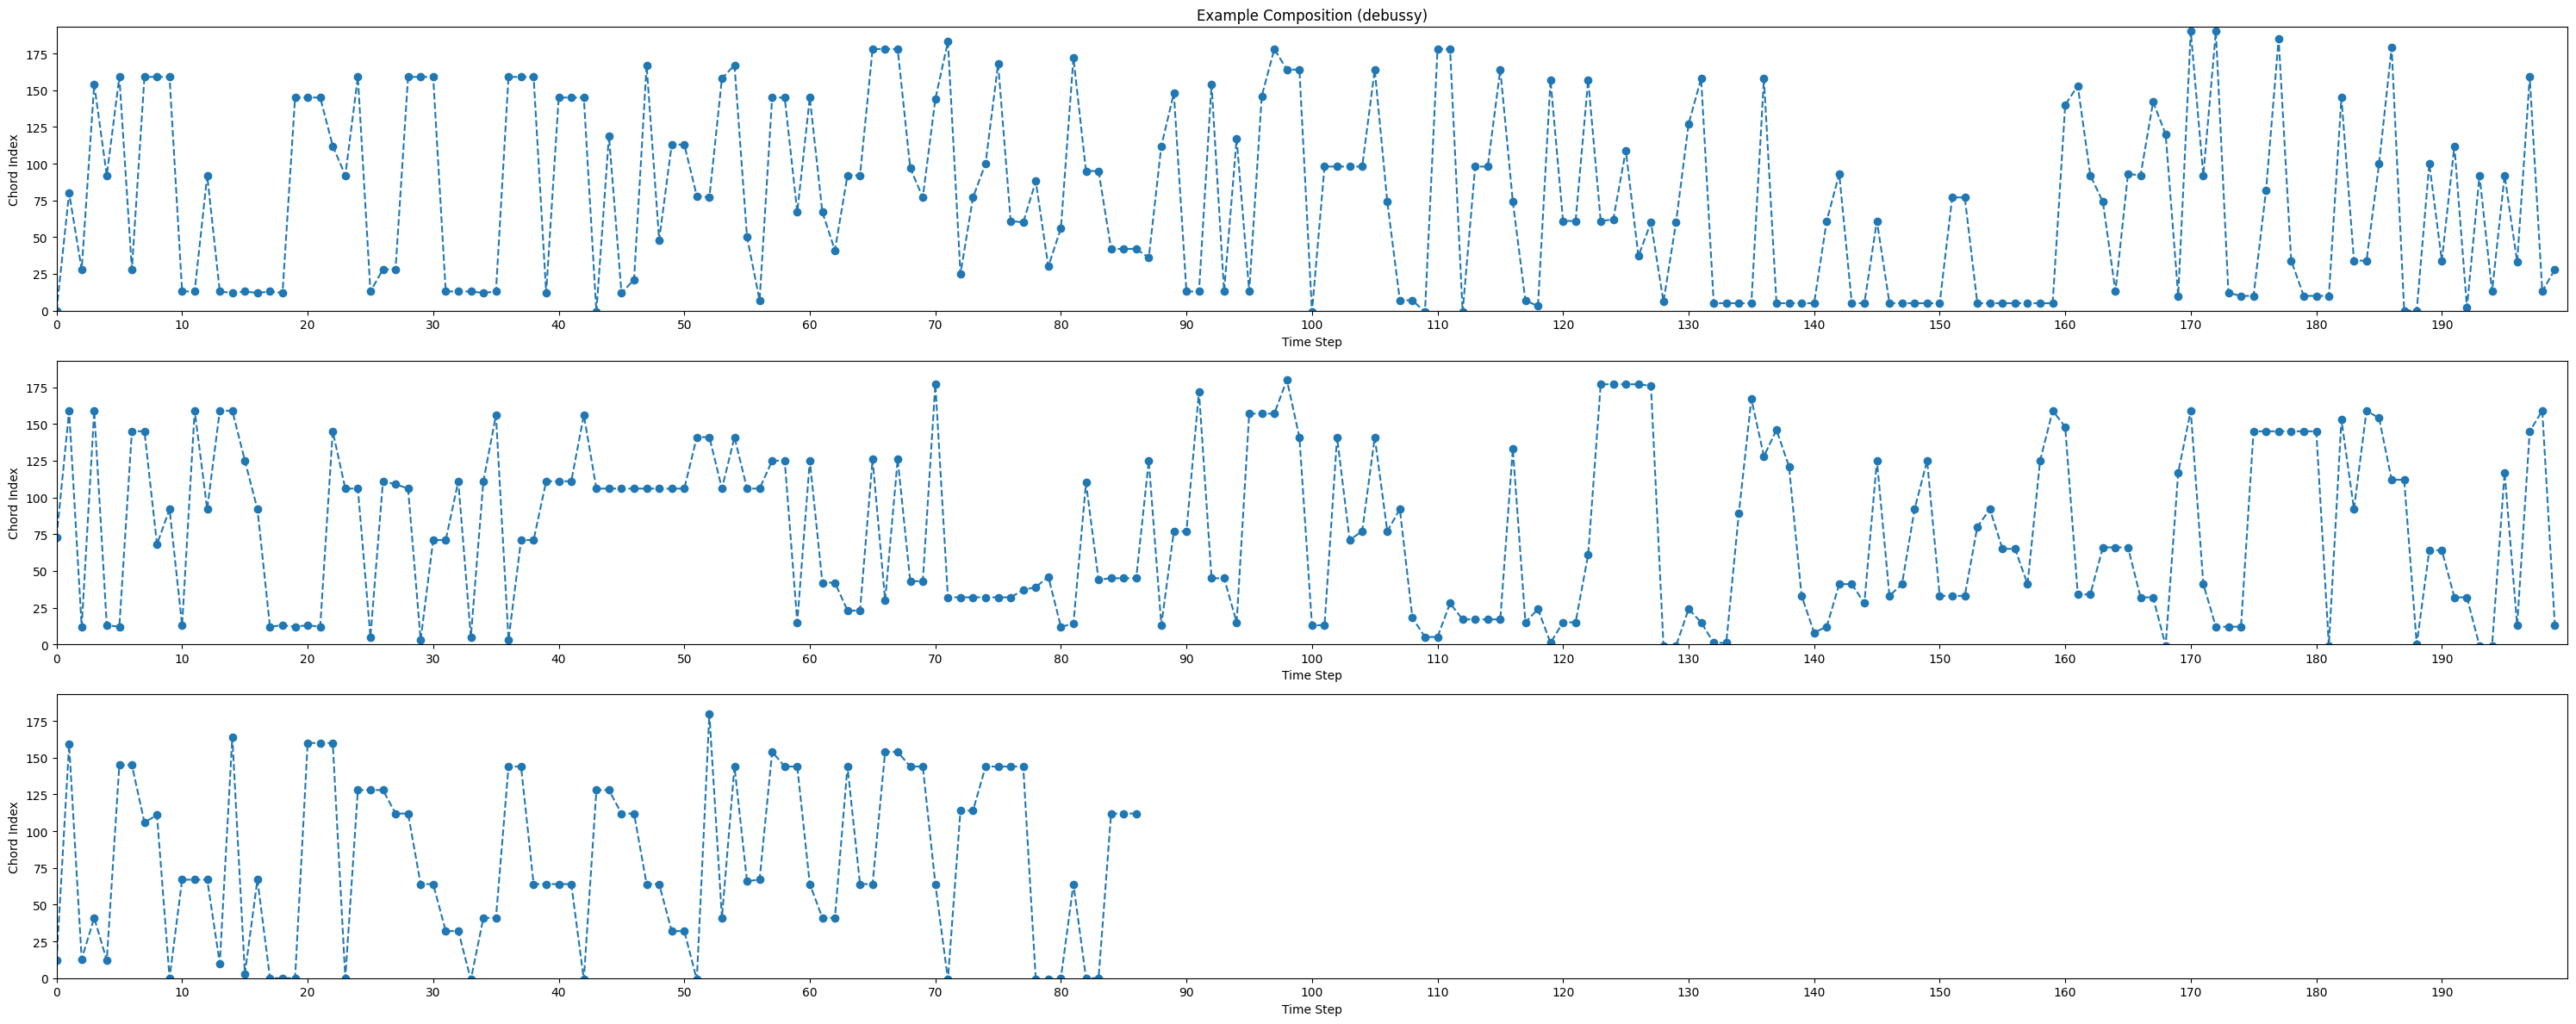

In [8]:
sample_idx = random.randint(0, len(sequences) - 1)

sample_seq = sequences[sample_idx]
sample_label = labels[sample_idx]

plot_sequence(sample_seq, sample_label)

Plot the class distribution

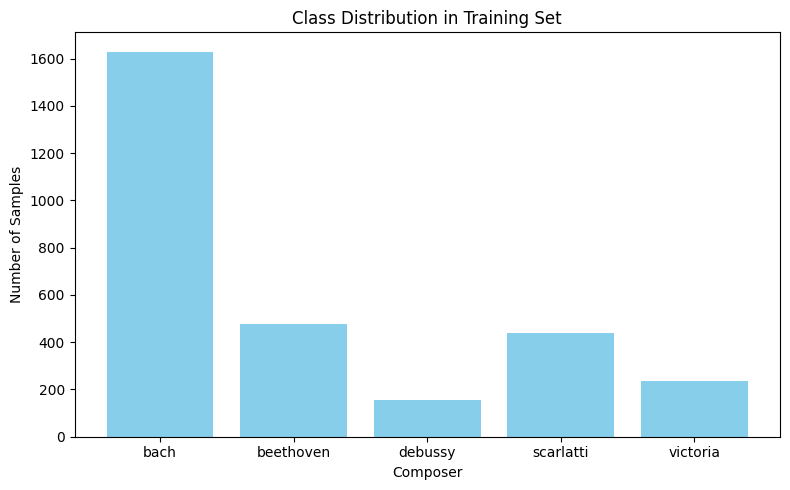

In [9]:
counts = np.bincount(labels, minlength=len(compositors))
class_names = [compositors[i] for i in range(len(counts))]

plt.figure(figsize=(8, 5))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel("Composer")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.tight_layout()
plt.show()

Plot the length distribution per class

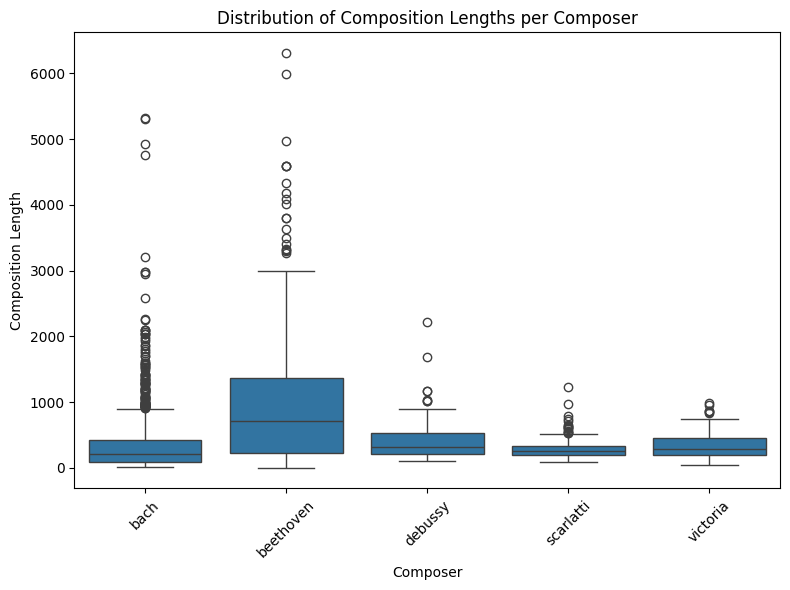

In [11]:
import seaborn as sns

lengths = [len(seq) for seq in sequences]

plt.figure(figsize=(8, 6))
sns.boxplot(x=[compositors[l] for l in labels], y=lengths)
plt.xlabel("Composer")
plt.ylabel("Composition Length")
plt.title("Distribution of Composition Lengths per Composer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
sequences

[tensor([ -1,  -1,  -1,  ...,  78,  40, 144]),
 tensor([ -1,  -1, 144,  ...,  32,  -1,  -1]),
 tensor([ 66, 100, 148, 148, 146,  64, 146, 148,  82,   0,  82, 100,  34, 132,
         180,  65,  80,  81, 131,  52,  34,  52,  64,  52,   3,  66, 147,  20,
           4, 132, 132, 100, 111,  74, 110,  60,  92,  65, 100, 189,  44,   8,
           5,  76,  31, 159,   5, 124,   4,  12,  51, 157,  57,  31, 183,  57,
          65,  92,  69, 124, 122,  79, 110,  76,  12,  12,  12,  12,   8, 159,
          12, 156, 100, 111,  52, 121,  36,  47,  41,  41,   8, 172,  38,  12,
          78,  12,  88,  47, 119,  20,  47,  12, 159,  20,  20,  76,  60, 110,
         132, 185, 120,  45, 110, 110,  72, 124, 178,  73,   8,  78,  12,  42,
         173,  12, 150,  84,  66, 152,  69,   8,  41, 159,   5,  78,  44, 180,
          71,  92, 152,   6,  12,  45,  92, 125,   8, 156,  12,  12, 146,   8,
         185,   0,  88,  92,  90,  12,  12,  12,  78,  92,   3,  45, 111, 111,
          71, 137,  69,  12,  88,  12